In [2]:
import bagpy
from bagpy import bagreader
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import filtfilt, butter

In [3]:
#Part A - Finding Yaw angle corrections calculated from magnetometer
#Load circle data into pandas dataframe

data_set = bagreader('/home/shreejit/Lab1_analysis/circles.bag')
df = data_set.message_by_topic(topic = '/imu')
imu_df = pd.read_csv(df)

[INFO]  Data folder /home/shreejit/Lab1_analysis/circles already exists. Not creating.


In [4]:
#Back conversion of queternion to Euler angles

x = imu_df['IMU.orientation.x'].to_numpy()
y = imu_df['IMU.orientation.y'].to_numpy()
z = imu_df['IMU.orientation.z'].to_numpy()
w = imu_df['IMU.orientation.w'].to_numpy()

t0 = []
t1 = []
t2 = []
t3 = []
t4 = []
roll_x = []
pitch_y = []
yaw_z = []

for i in range(len(x)):
    t0.append(+2.0 * (w[i] * x[i] + y[i] * z[i]))
    t1.append(+1.0 - 2.0 * (x[i] * x[i] + y[i] * y[i]))
    roll_x.append(math.atan2(t0[i], t1[i]))
     
    t2.append(+2.0 * (w[i] * y[i] - z[i] * x[i]))
    if t2[i] > +1.0:
        t2[i] =+1.0
    if t2[i] < -1.0:
        t2[i] = -1.0
    pitch_y.append(math.asin(t2[i]))
     
    t3.append(+2.0 * (w[i] * z[i] + x[i] * y[i]))
    t4.append(+1.0 - 2.0 * (y[i] * y[i] + z[i] * z[i]))
    yaw_z.append(math.atan2(t3[i], t4[i]))
    
imu_df['Roll_conv'] = np.array(roll_x)
imu_df['Pitch_conv'] = np.array(pitch_y)
imu_df['Yaw_conv'] = np.array(yaw_z)

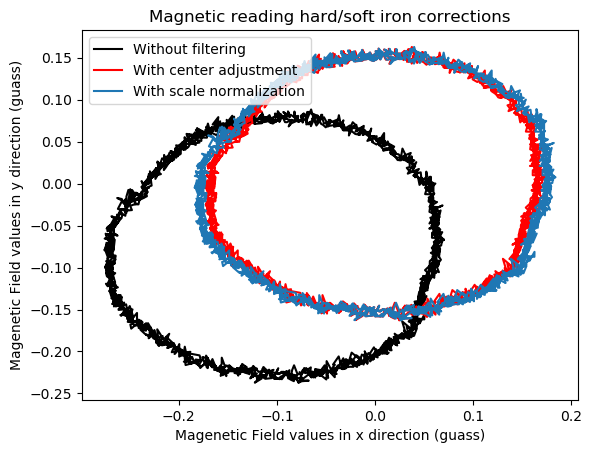

In [5]:
#Adjusting magnetic field readings for hard and soft iron corrections

magx = np.array(imu_df['MagField.magnetic_field.x'])
magy = np.array(imu_df['MagField.magnetic_field.y'])
magz = np.array(imu_df['MagField.magnetic_field.z'])

plt.plot(magx[300:], magy[300:], label = 'Without filtering', color = 'black')

#Adjustment offset
X_off_center = (max(magx[300:])+min(magx[300:]))/2
Y_off_center = (max(magy[300:])+min(magy[300:]))/2

magx = magx - X_off_center
magy = magy - Y_off_center

#Adjustment Scale
scale_fac = max(magy[300:])/max(magx[300:])


plt.plot(magx[300:], magy[300:], label = 'With center adjustment', color='red')

magx = magx/scale_fac

#Plots
plt.plot(magx[300:], magy[300:], label = 'With scale normalization')
plt.xlabel('Magenetic Field values in x direction (guass)')
plt.ylabel('Magenetic Field values in y direction (guass)')
plt.title('Magnetic reading hard/soft iron corrections')
plt.legend(loc = 2)
plt.show()

In [6]:
#Finding Yaw angle from the corrected magnetic flux values

yaw = []
for i in range(len(magy)):
    yaw.append(math.radians(180 * math.atan2(-magy[i],magx[i]) / math.pi))

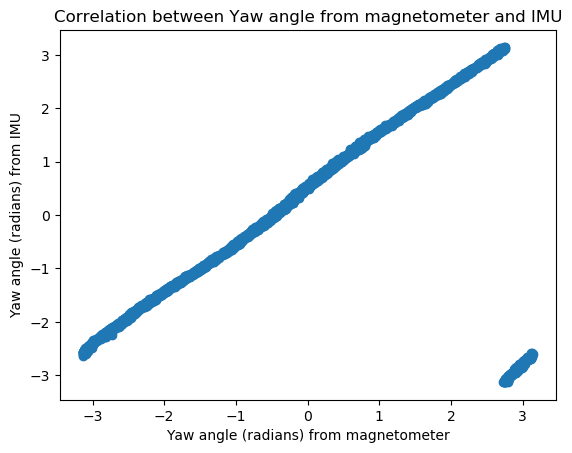

In [7]:
#Plots

plt.scatter(yaw,yaw_z)
plt.xlabel('Yaw angle (radians) from magnetometer')
plt.ylabel('Yaw angle (radians) from IMU')
plt.title('Correlation between Yaw angle from magnetometer and IMU')
plt.show()

In [8]:
#Part B - Dead Reckoning

#Loading data - Mini Tour
data_set = bagreader('/home/shreejit/Lab1_analysis/boston_tour.bag')
df_2 = data_set.message_by_topic(topic = '/imu')
df_3 = data_set.message_by_topic(topic = '/gps')
imu_df2 = pd.read_csv(df_2)
gps_df2 = pd.read_csv(df_3)

[INFO]  Data folder /home/shreejit/Lab1_analysis/boston_tour already exists. Not creating.


In [9]:
#Back conversion of queternion to Euler angles

x = imu_df2['IMU.orientation.x'].to_numpy()
y = imu_df2['IMU.orientation.y'].to_numpy()
z = imu_df2['IMU.orientation.z'].to_numpy()
w = imu_df2['IMU.orientation.w'].to_numpy()

t0 = []
t1 = []
t2 = []
t3 = []
t4 = []
roll_x = []
pitch_y = []
yaw_z = []

for i in range(len(x)):
    t0.append(+2.0 * (w[i] * x[i] + y[i] * z[i]))
    t1.append(+1.0 - 2.0 * (x[i] * x[i] + y[i] * y[i]))
    roll_x.append(math.atan2(t0[i], t1[i]))
     
    t2.append(+2.0 * (w[i] * y[i] - z[i] * x[i]))
    if t2[i] > +1.0:
        t2[i] =+1.0
    if t2[i] < -1.0:
        t2[i] = -1.0
    pitch_y.append(math.asin(t2[i]))
     
    t3.append(+2.0 * (w[i] * z[i] + x[i] * y[i]))
    t4.append(+1.0 - 2.0 * (y[i] * y[i] + z[i] * z[i]))
    yaw_z.append(math.atan2(t3[i], t4[i]))
    
imu_df2['Roll_conv'] = np.array(roll_x)
imu_df2['Pitch_conv'] = np.array(pitch_y)
imu_df2['Yaw_conv'] = np.array(yaw_z)

In [10]:
#Normalizing time values

imu_time = imu_df2['Time'] - imu_df2['Time'][0]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


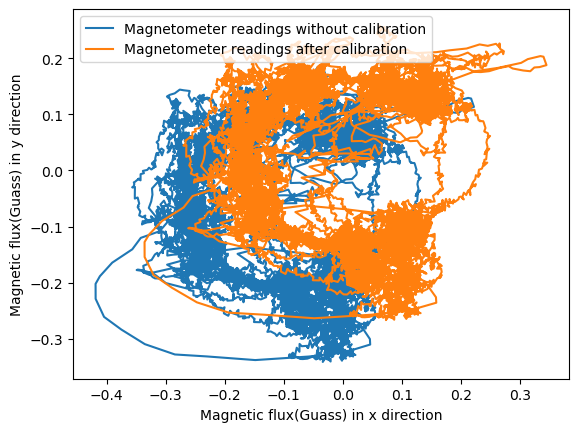

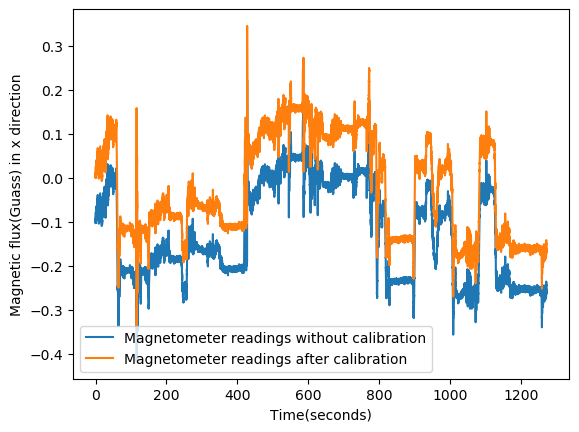

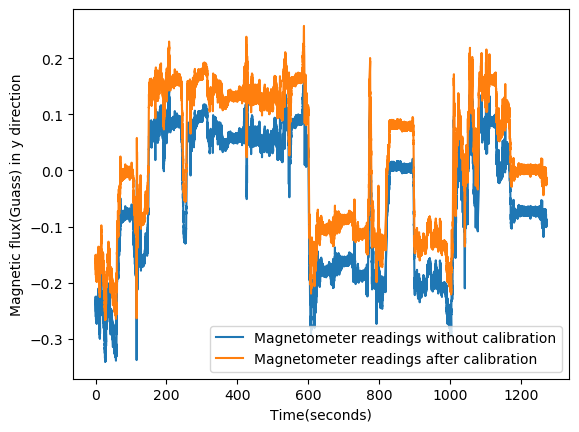

In [11]:
#Adjusting Magnetic Readings with the corrections from circles.bag 

magx_2 = np.array(imu_df2['MagField.magnetic_field.x'])
magy_2 = np.array(imu_df2['MagField.magnetic_field.y'])
magz_2 = np.array(imu_df2['MagField.magnetic_field.z'])

#Center offset
magx_2 = magx_2 - X_off_center
magy_2 = magy_2 - Y_off_center

#Adjustment
magx_2 = magx_2/scale_fac

YAW_mag = []

for i in range(len(magy_2)):
    YAW_mag.append(math.radians(180 * math.atan2(-magy_2[i],magx_2[i]) / math.pi))

#Plots 
plt.plot(imu_df2['MagField.magnetic_field.x'], imu_df2['MagField.magnetic_field.y'], label = 'Magnetometer readings without calibration')
plt.plot(magx_2,magy_2, label = 'Magnetometer readings after calibration')
plt.xlabel('Magnetic flux(Guass) in x direction')
plt.ylabel('Magnetic flux(Guass) in y direction')
plt.legend()
plt.show()
         
plt.plot(imu_time, imu_df2['MagField.magnetic_field.x'], label = 'Magnetometer readings without calibration')
plt.plot(imu_time,magx_2, label = 'Magnetometer readings after calibration')
plt.xlabel('Time(seconds)')
plt.ylabel('Magnetic flux(Guass) in x direction')
plt.legend()
plt.show()
         
plt.plot(imu_time, imu_df2['MagField.magnetic_field.y'], label = 'Magnetometer readings without calibration')
plt.plot(imu_time,magy_2, label = 'Magnetometer readings after calibration')
plt.xlabel('Time(seconds)')
plt.ylabel('Magnetic flux(Guass) in y direction')
plt.legend()
plt.show()

In [12]:
    
# Filter for fluctuation between pi and -pi
for i in range(len(YAW_mag)):
    try:
        if (abs(YAW_mag[i+1] - YAW_mag[i]) > 5):
            YAW_mag[i+1] = YAW_mag[i]
    except:
        pass

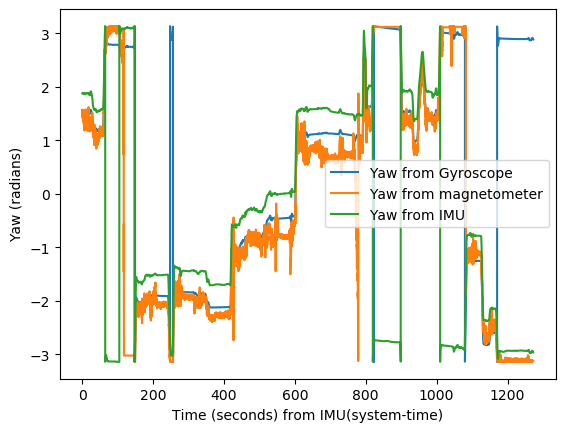

In [13]:
#Finding yaw angles from gyroscope for sensor fusion

yaw_from_gyro = scipy.integrate.cumtrapz(imu_df2['IMU.angular_velocity.z'],imu_time)

#Initial reading offset
yaw_from_gyro = yaw_from_gyro + YAW_mag[0]

#For conversion of values between (0, 2pi) to (-pi, pi)
YAW_gyro = np.unwrap(yaw_from_gyro)
for i, a in enumerate(YAW_gyro):
    while a < math.pi:
        a += 2 * math.pi
    while a > math.pi:
        a -= 2 * math.pi
    YAW_gyro[i] = a
    
#Plots
plt.plot(imu_time[1:], YAW_gyro, label='Yaw from Gyroscope')
plt.plot(imu_time, YAW_mag, label ='Yaw from magnetometer')
plt.plot(imu_time, imu_df2['Yaw_conv'], label ='Yaw from IMU')
plt.xlabel('Time (seconds) from IMU(system-time)')
plt.ylabel('Yaw (radians)')
plt.legend()
plt.show()
# print(YAW_mag[0])

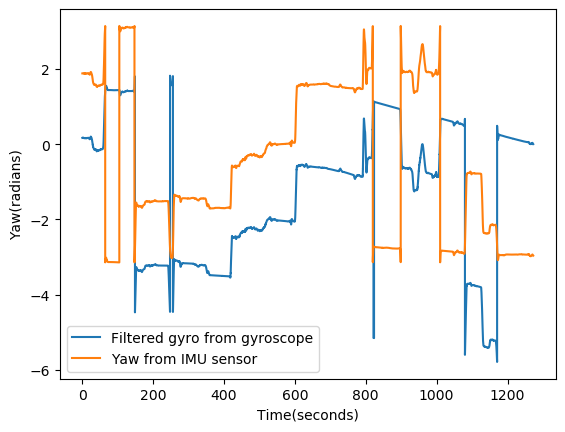

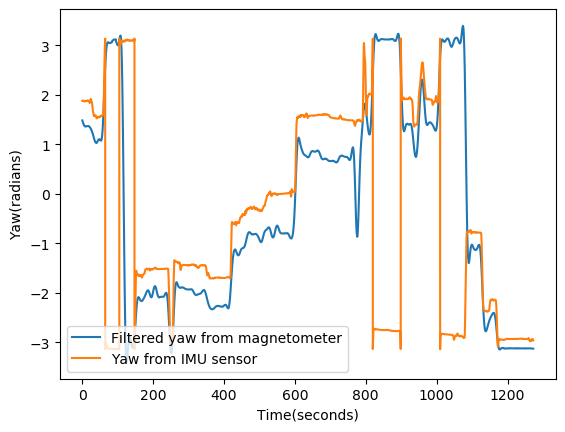

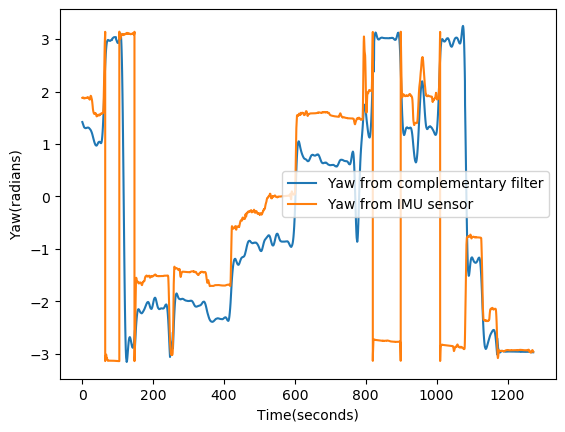

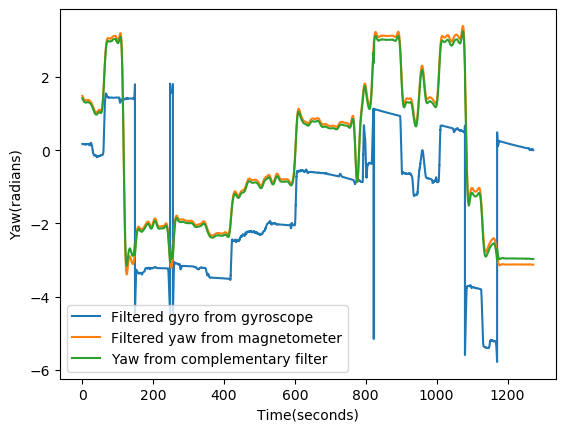

In [14]:
#Filtering data with high-pass and low-pass filter from gyroscope and magnetometer

#Initializing values for the filters
alpha=0.05
highpass=.00001
lowpass=.003

#High pass filter for yaw from gyroscope
YAW_gyro_filtered = filtfilt(*butter(1, highpass, btype='high'), YAW_gyro, axis=0)

# Low pass filter for yaw from magnetometer
YAW_mag_filtered = filtfilt(*butter(4, lowpass, btype='low'), YAW_mag, axis=0)


#plots
# plt.plot(imu_time[1:], YAW_gyro, label='Yaw from gyro', color = 'blue')
plt.plot(imu_time[1:], YAW_gyro_filtered, label='Filtered gyro from gyroscope')
plt.plot(imu_time, imu_df2['Yaw_conv'], label = 'Yaw from IMU sensor')
plt.xlabel('Time(seconds)')
plt.ylabel('Yaw(radians)')
plt.legend()
plt.show()

# plt.plot(imu_time, YAW_mag, label='Yaw from magnetometer', color = 'blue')
plt.plot(imu_time, YAW_mag_filtered, label='Filtered yaw from magnetometer')
plt.plot(imu_time, imu_df2['Yaw_conv'], label = 'Yaw from IMU sensor')
plt.xlabel('Time(seconds)')
plt.ylabel('Yaw(radians)')
plt.legend()
plt.show()

#Complementary Filter
Yaw_comp = YAW_gyro_filtered * alpha + YAW_mag_filtered[1:] * (1 - alpha)
plt.plot(imu_time[1:], Yaw_comp, label = 'Yaw from complementary filter')
plt.plot(imu_time, imu_df2['Yaw_conv'], label = 'Yaw from IMU sensor')
plt.xlabel('Time(seconds)')
plt.ylabel('Yaw(radians)')
plt.legend()
plt.show()

#All filtered plots
plt.plot(imu_time[1:], YAW_gyro_filtered, label='Filtered gyro from gyroscope')
plt.plot(imu_time, YAW_mag_filtered, label='Filtered yaw from magnetometer')
plt.plot(imu_time[1:], Yaw_comp, label = 'Yaw from complementary filter')
plt.xlabel('Time(seconds)')
plt.ylabel('Yaw(radians)')
plt.legend()
plt.show()

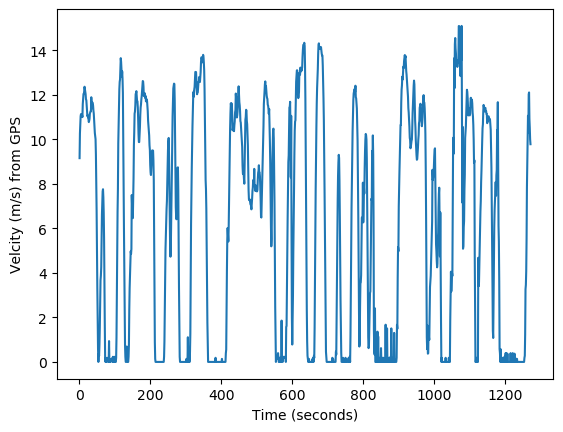

In [15]:
#Velocity from GPS

#Initialization
Gps_time = gps_df2['Time']
North_posi = gps_df2['UTM_northing']
East_posi = gps_df2['UTM_easting']

#Normalizing the time from GPS
Gps_time = np.around(Gps_time - Gps_time[0])

#Instantaneous velocity from GPS
inst_north = np.diff(North_posi)
inst_east = np.diff(East_posi)
gdt = np.diff(Gps_time)

velo_gps = []
# time_when_velo_0 = []

for i in range(len(gdt)):
    velo_gps.append(math.sqrt(inst_north[i]**2 + inst_east[i]**2))
#     if (velo_gps[i] >= 0 and velo_gps[i] <= 0.05):
#         time_when_velo_0.append(i)

plt.plot(Gps_time[1:],velo_gps)
plt.xlabel('Time (seconds)')
plt.ylabel('Velcity (m/s) from GPS')
plt.show()

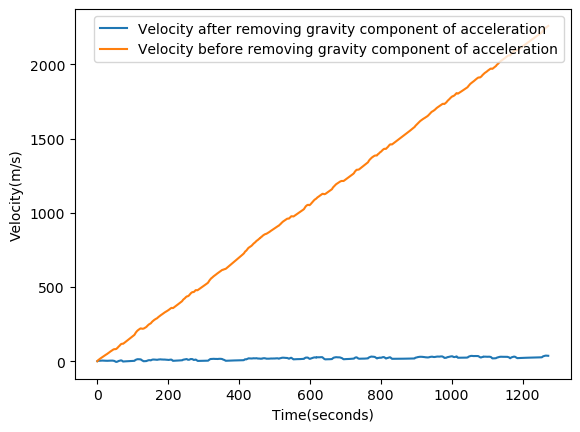

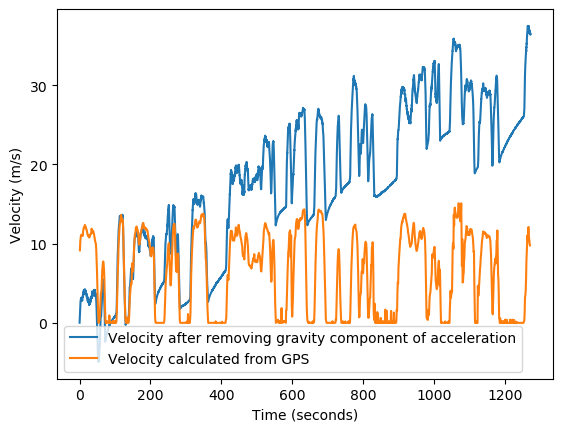

In [16]:
#Finding velocity from acceleration of IMU

acclx = np.array(imu_df2['IMU.linear_acceleration.x'])
accly = np.array(imu_df2['IMU.angular_velocity.y'])
acclz = np.array(imu_df2['IMU.linear_acceleration.z'])

# Calculating instantaneous velocity from accelration

dt = np.diff(imu_time)

# Manual integration
# v_inst = []
# v_initial = 0
# for i in range(len(dt)):
#     v_inst.append(v_initial + acclx[i]*dt[i] - acclx[i])
#     v_initial = v_inst[i]

# plt.plot(imu_time[1:], v_inst, label = 'Heading Velocity')
# plt.legend()

#Net acceleration subtracting gravitational component from velo in heading direction
res_acclx = []
for i in range(len(acclx)):
    res_acclx.append(acclx[i] - abs(acclz[i] * math.sin(pitch_y[i])))

#Velocity by integration of acceleration
velo_prev = scipy.integrate.cumtrapz(acclx, imu_time)
velo = scipy.integrate.cumtrapz(res_acclx, imu_time)

#Plots
plt.plot(imu_time[1:], velo, label = 'Velocity after removing gravity component of acceleration')
plt.plot(imu_time[1:], velo_prev, label = 'Velocity before removing gravity component of acceleration')
plt.xlabel('Time(seconds)')
plt.ylabel('Velocity(m/s)')
plt.legend()
plt.show()

plt.plot(imu_time[1:], velo, label = 'Velocity after removing gravity component of acceleration')
plt.plot(Gps_time[1:],velo_gps, label = 'Velocity calculated from GPS')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

In [17]:
#Refining for bias
Refine_n = 3
imu_time = np.array(imu_time)
velo_fit = velo

for i in range(Refine_n):
    poly = np.polyfit(imu_time[1:], velo_fit, 1)
    velo_fit = velo_fit - (poly[0]*imu_time[1:]+poly[1])

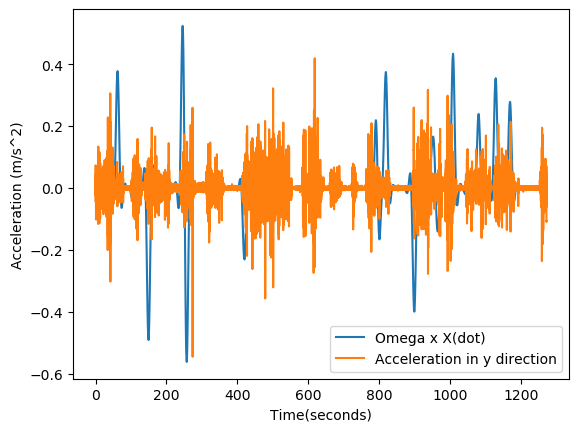

In [18]:
#Calculating angular velocity
lowpass_angv = 0.003
# lowpass_accly = 0.025
Wz = imu_df2['IMU.angular_velocity.z']
Angular_vel = Wz[:-1] * Yaw_comp

Ang_mag_filtered = filtfilt(*butter(4, lowpass_angv, btype='low'), Angular_vel, axis=0)
# Accy_mag_filtered = filtfilt(*butter(4, lowpass_accly, btype='low'), accly, axis=0)

# plt.plot(imu_time[:-1], Angular_vel, label = 'Angular velocity(rad/sec) in Z direction')
plt.plot(imu_time[:-1], Ang_mag_filtered, label = 'Omega x X(dot)')
plt.plot(imu_time, accly, label = 'Acceleration in y direction')
plt.xlabel('Time(seconds)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()
# plt.plot(imu_time, Accy_mag_filtered, label = 'Acceleration(m/s^2) in y Yiltered')

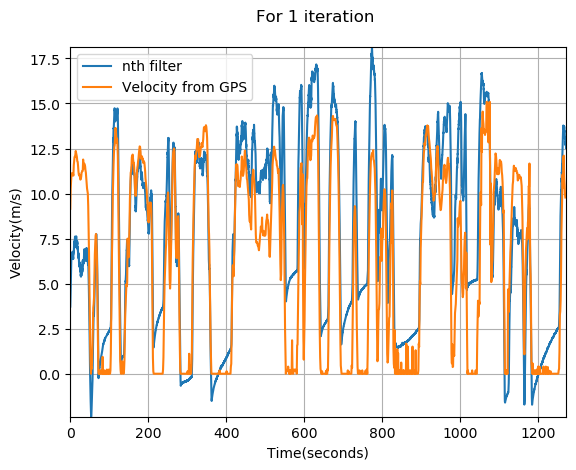

In [19]:
#Second loop filtering

for_slope_list = []
its_time = []
number_filter = 1
nth_filtered_velo = velo_fit

for i in range(number_filter):
    for j in range(len(nth_filtered_velo)):
        if (nth_filtered_velo[j] < np.min(nth_filtered_velo[25448:33930])):
            for_slope_list.append(nth_filtered_velo[j])
            its_time.append(imu_time[j])
        
    poly_2 = np.polyfit(its_time, for_slope_list, 1)
    
    nth_filtered_velo = nth_filtered_velo - (poly_2[0]*imu_time[1:]+poly_2[1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.margins(x=0, y=0)
#     grid_points = range(0,1300,50)
#     ax.xaxis.set_ticks(grid_points)
    ax.grid(True)
 
    ax.plot(imu_time[1:], nth_filtered_velo, label = 'nth filter')
    ax.plot(range(0,1271,1), velo_gps, label = 'Velocity from GPS')
    plt.title('For ' + str(i+1) + ' iteration \n')
    plt.xlabel('Time(seconds)')
    plt.ylabel('Velocity(m/s)')
    ax.legend()
    plt.show()
    

In [20]:
#For finding range of bins

start_t = 1025
end_t = 1075
start_bin = round(start_t*50897/1272)
end_bin = round(end_t*50897/1272)
print(start_bin,end_bin)

41014 43014


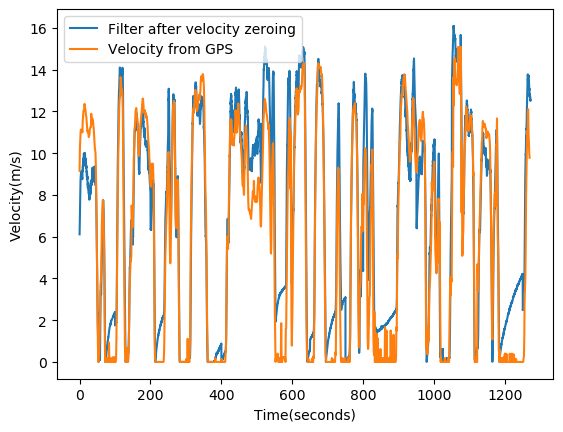

In [21]:
#Filtering with bins

fiter_nth = nth_filtered_velo

#bin1

fiter_nth[0:2295] = fiter_nth[0:2295] - np.min(fiter_nth[0:2295])

#bin2

fiter_nth[4001:6002] = fiter_nth[4001:6002] - np.min(fiter_nth[4001:6002])

#bin3

fiter_nth[8003:10003] = fiter_nth[8003:10003] - np.min(fiter_nth[8003:10003])

#bin4

fiter_nth[12004:14005] = fiter_nth[12004:14005] - np.min(fiter_nth[12004:14005])

#bin5

fiter_nth[16005:22007] = fiter_nth[16005:22007] - np.min(fiter_nth[16005:22007])

#bin6

fiter_nth[22007:26009] = fiter_nth[22007:26009] - np.min(fiter_nth[22007:26009])

#bin7

fiter_nth[26009:30010] = fiter_nth[26009:30010] - np.min(fiter_nth[26009:30010])

#complementary bin

fiter_nth[30010:32011] = fiter_nth[30010:32011] - np.min(fiter_nth[30010:32011])

#bin8

fiter_nth[38013:42014] = fiter_nth[38013:42014] - np.min(fiter_nth[38013:42014])

#complementary bin

fiter_nth[41014:43014] = fiter_nth[41014:43014] - np.min(fiter_nth[41014:43014])

#bin9

fiter_nth[43014:50017] = fiter_nth[43014:50017] - np.min(fiter_nth[43014:50017])

for i in range(len(fiter_nth)):
    if fiter_nth[i]<0:
        fiter_nth[i] = 0

final_filtered_velocity = fiter_nth
plt.plot(imu_time[1:], fiter_nth, label = 'Filter after velocity zeroing')
plt.plot(range(0,1271,1), velo_gps, label = 'Velocity from GPS')
plt.xlabel('Time(seconds)')
plt.ylabel('Velocity(m/s)')
plt.legend()

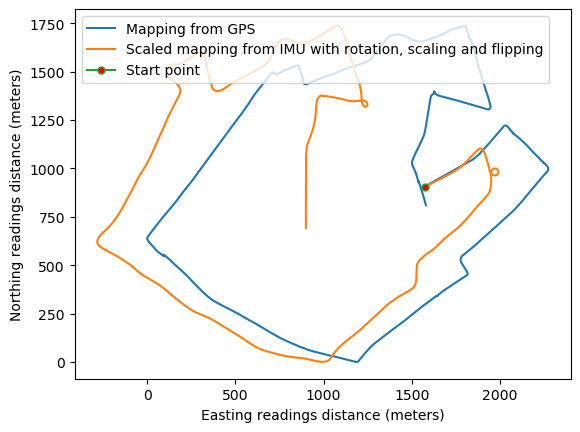

In [22]:
#Mapping northing and easting readings from IMU and GPS

#Finding distance covered as a function of time
vel_n = []
vel_e = []

for i in range(len(fiter_nth)):
    vel_n.append(fiter_nth[i] * math.sin(Yaw_comp[i]))

for i in range(len(fiter_nth)):
    vel_e.append(fiter_nth[i] * math.cos(Yaw_comp[i]))
    
dist_n = scipy.integrate.cumtrapz(vel_n,imu_time[:-1])
dist_e = scipy.integrate.cumtrapz(vel_e,imu_time[:-1])

dist_n = dist_n - np.min(dist_n)
dist_e = dist_e - np.min(dist_e)

# plt.xlabel('Distance in Easting in meters')
# plt.ylabel('Distance in Northing in meters')
# plt.plot(dist_e, dist_n, label = 'Mapping from IMU')

northing = np.array(gps_df2['UTM_northing'])
easting = np.array(gps_df2['UTM_easting'])

northing = northing - np.min(northing)
easting = easting - np.min(easting)

plt.plot(easting, northing, label = 'Mapping from GPS')

#Same initial point
north_offset = dist_n[0] - northing[0]
east_offset = dist_e[0] - easting[0]

off_dist_e = dist_e - east_offset
off_dist_n = dist_n - north_offset

final_dist_n = []

#Flipping the mapping
for i in range(len(off_dist_n)):
    if (off_dist_n[i] == off_dist_n[0]):
        final_dist_n.append(off_dist_n[i])
    else:
        offset = off_dist_n[i] - off_dist_n[0]
        final_dist_n.append(off_dist_n[i] - 2*offset)
        
#Rotation about a point
def rotate(point, origin, degrees):
    radians = np.deg2rad(degrees)
    x,y = point
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return qx, qy

rotated_n = []
rotated_e = []
for i in range(len(off_dist_e)):
    qx, qy = rotate((off_dist_e[i],final_dist_n[i]),(off_dist_e[0],off_dist_n[0]), -100)
    rotated_e.append(qx)
    rotated_n.append(qy)

#Scaling factors
stretching_scale_e = (np.max(easting) - np.min(easting)) / (np.max(rotated_e) - np.min(rotated_e))
stretching_scale_n = (np.max(northing) - np.min(northing)) / (np.max(rotated_n) - np.min(rotated_n))

scaled_dist_e = (np.array(rotated_e))*stretching_scale_e
scaled_dist_n = (np.array(rotated_n))*stretching_scale_n

#Same initial point
north_offset = scaled_dist_n[0] - northing[0]
east_offset = scaled_dist_e[0] - easting[0]

final_dist_e = scaled_dist_e - east_offset
final_dist_n = scaled_dist_n - north_offset

    
#Plots
plt.plot(final_dist_e, final_dist_n, label = 'Scaled mapping from IMU with rotation, scaling and flipping')
# plt.plot(off_dist_e,final_dist_n, label = 'Flipping')
# plt.plot(off_dist_e,off_dist_n, label = 'Scaled mapping from IMU without rotation')
plt.xlabel('Easting readings distance (meters)')
plt.ylabel('Northing readings distance (meters)')
plt.plot(easting[0], northing[0], marker="o", markersize=5, markerfacecolor="red", label='Start point')
plt.legend(loc = 2)
plt.show()

In [23]:
#Accuracy range upto 2 m
for i in range(len(final_dist_e)):
    offset_between_pts = math.sqrt((final_dist_n[i] - northing[i])**2 + (final_dist_e[i] - easting[i])**2)
    if offset_between_pts > 2:
        break
print(i)

1


In [82]:
print('The scaling factor in east :' + str(stretching_scale_e) + '\n')
print('The scaling factor in north :' + str(stretching_scale_n))

The scaling factor in east :0.8325660586501613

The scaling factor in north :0.8418220080050847
